In [3]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn

In [4]:
classes_names_indiana_pines = ["Alfalfa", "Corn-notill", 
"Corn-mintill", "Corn", "Grass-pasture", "Grass-trees",
"Grass-pasture-mowed", "Hay-windrowed", "Oats", "Soybean-notill",
"Soybean-mintill", "Soybean-clean", "Wheat", "Woods", 
"Buildings-grass-Trees-Drives", "Stone-Steel-Towers"]

classes_names_salinas = ["Brocoli_green_weeds_1", 
"Brocoli_green_weeds_2", "Fallow", "Fallow_rough_plow", 
"Fallow_smooth", "Stubble", "Celery", "Grapes_untrained",
"Soil_vinyard_develop", "Corn_senesced_green_weeds", "Lettuce_romaine_4wk", 
"Lettuce_romaine_5wk", "Lettuce_romaine_6wk", "Lettuce_romaine_7wk", 
"Vinyard_untrained", "Vinyard_vertical_trellis"]

### Load and Display Images

In [5]:
salinas = np.load('salinas.npy', allow_pickle=True)
salinas_gt = np.load('salinas_gt.npy', allow_pickle=True)
print(salinas.shape)
print(salinas_gt.shape)

(512, 217, 204)
(512, 217)


In [6]:
indiana_pines = np.load('indianapines.npy', allow_pickle=True)
indiana_pines_gt = np.load('indianapines_gt.npy', allow_pickle=True)
print(indiana_pines.shape)
print(indiana_pines_gt.shape)

(145, 145, 200)
(145, 145)


In [7]:
def plot_RGB(image):
    imageRGB = np.array(image[:, :, [30, 15, 2]], dtype=float)

    pmin,pmax = np.percentile(imageRGB, (1,99), axis=(0,1))
    print(pmin, pmax)
    imageRGB_pimped = imageRGB.copy()

    for i in range(pmin.size):
        imageRGB_pimped[:,:,i] = (imageRGB[:,:,i] - pmin[i]) / (pmax[i] - pmin[i])

    imageRGB_pimped[imageRGB_pimped < 0] = 0
    imageRGB_pimped[imageRGB_pimped > 1] = 1

    plt.figure(figsize=(5,5))
    plt.imshow(imageRGB_pimped)
    plt.show()

[ 600. 1045.  474.] [3747. 3107.  927.]


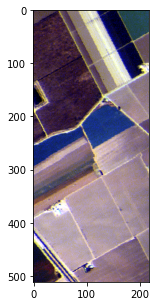

In [8]:
plot_RGB(salinas)

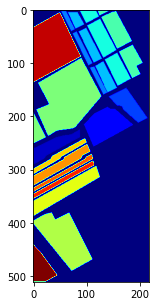

In [9]:
plt.figure(figsize=(5,5))
plt.imshow(salinas_gt, cmap='jet')

[2353. 2761. 3833.] [5442.   6051.76 4946.  ]


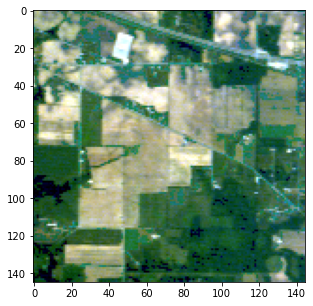

In [10]:
plot_RGB(indiana_pines)

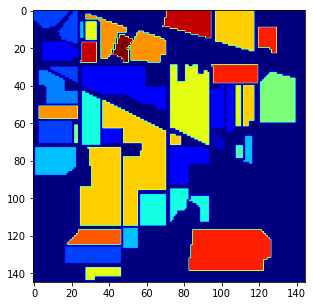

In [11]:
plt.figure(figsize=(5,5))
plt.imshow(indiana_pines_gt, cmap='jet')

### PCA

In [12]:
def flatten_image(X):
    return X.reshape((-1, X.shape[-1]))

X1 = flatten_image(salinas)
Y1 = salinas_gt.flatten()

X1 = X1[Y1!=0]
Y1 = Y1[Y1!=0]
Y1 = Y1 - 1
values, count = np.unique(Y1, return_counts=True)
print(values, '\n', count)
print(X1.shape)
print(Y1.shape)

X2 = flatten_image(indiana_pines)
Y2 = indiana_pines_gt.flatten()

X2 = X2[Y2!=0]
Y2 = Y2[Y2!=0]
Y2 = Y2 - 1
print(X2.shape)
print(Y2.shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
 [ 2009  3726  1976  1394  2678  3959  3579 11271  6203  3278  1068  1927
   916  1070  7268  1807]
(54129, 204)
(54129,)
(10249, 200)
(10249,)


In [13]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.2, random_state=1, stratify=Y1)
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.2, random_state=1, stratify=Y2)
print(X1_train.shape)
print(X2_train.shape)

(43303, 204)
(8199, 200)


In [14]:
from sklearn.decomposition import PCA

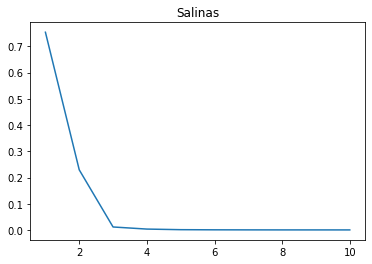

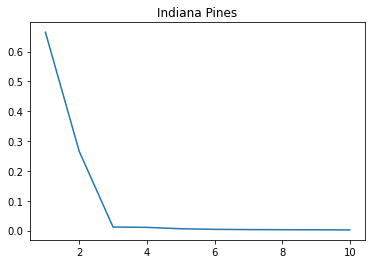

In [15]:
from sklearn import decomposition

def pca_components(X, name):
    pca = decomposition.PCA(n_components=10)
    pca.fit(X)

    plt.plot(np.arange(1, 11), pca.explained_variance_ratio_)
    plt.title(name)
    plt.show()

pca_components(X1, "Salinas")
pca_components(X2, "Indiana Pines")

Variance greater than 0.999: 3


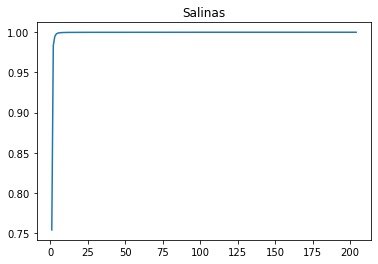

Variance greater than 0.999: 34


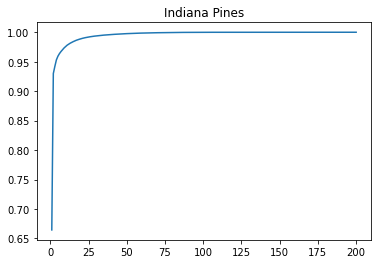

In [16]:
def pca_components_cumsum(X, name):
    pca = decomposition.PCA()
    pca.fit(X)

    variances = np.cumsum(pca.explained_variance_ratio_)
    print("Variance greater than 0.999:", np.argmax(variances > 0.995))

    plt.plot(np.arange(1, X.shape[-1] + 1), variances)
    plt.title(name)
    plt.show()

pca_components_cumsum(X1, "Salinas")
pca_components_cumsum(X2, "Indiana Pines")

In [17]:
pca1 = decomposition.PCA(n_components=20)
pca1.fit(X1)
print(pca1.components_.shape)

X1_pca = pca1.transform(X1)
print(X1_pca.shape)

(20, 204)
(54129, 20)


In [18]:
pca2 = decomposition.PCA(n_components=68)
pca2.fit(X2)
print(pca2.components_.shape)

X2_pca = pca2.transform(X2)
print(X2_pca.shape)

(68, 200)
(10249, 68)


### Classifier

In [96]:
from sklearn.utils import class_weight
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.kernel_approximation import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import *
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis, RadiusNeighborsClassifier


In [27]:
def class_weights(y):
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weights = dict(zip(np.arange(17), class_weights))

    print(class_weights)

    return class_weights

class_weights1 = class_weights(Y1)
class_weights2 = class_weights(Y2)

{0: 1.6839534594325536, 1: 0.9079609500805152, 2: 1.7120761639676114, 3: 2.4268741032998564, 4: 1.263279499626587, 5: 0.8545245011366507, 6: 0.945253562447611, 7: 0.3001563747671014, 8: 0.5453913428985975, 9: 1.032050793166565, 10: 3.1676615168539324, 11: 1.7556110534509601, 12: 3.6932996724890828, 13: 3.1617406542056075, 14: 0.4654736516235553, 15: 1.8721983951300498}
{0: 13.925271739130435, 1: 0.4485731792717087, 2: 0.771762048192771, 3: 2.702795358649789, 4: 1.3262163561076605, 5: 0.8774828767123287, 6: 22.877232142857142, 7: 1.3400889121338913, 8: 32.028125, 9: 0.6590149176954733, 10: 0.2609215885947047, 11: 1.0802065767284992, 12: 3.1246951219512193, 13: 0.5063735177865613, 14: 1.659488341968912, 15: 6.887768817204301}


In [67]:
extra_trees = ExtraTreesClassifier(n_estimators=700, max_features=6, max_depth=None, n_jobs=11, criterion='entropy', class_weight='balanced_subsample')

In [23]:
random_forest = RandomForestClassifier(n_estimators=700, max_features=6, n_jobs=11, criterion='entropy', class_weight='balanced_subsample')

In [24]:
knn = KNeighborsClassifier(algorithm='ball_tree', leaf_size=19, n_neighbors=8, weights='distance')

### Fit

In [124]:
clf = Pipeline([('normalizer', Normalizer()), ('dimred', LDA(solver='eigen', shrinkage='auto')),
    ('clf', sgd)])


In [125]:
clf.fit(X2_train, Y2_train)

Pipeline(steps=[('normalizer', Normalizer()),
                ('dimred',
                 LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen')),
                ('clf', SGDClassifier())])

In [126]:
clf.score(X2_test, Y2_test)

0.6385365853658537

In [57]:
print(sklearn.__version__)

0.24.2


In [29]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.neighbors import NeighborhoodComponentsAnalysis as NCA
pipe = clf
lda = LDA(solver='eigen', shrinkage='auto')

grid_params = [{
    'clf': [extra_trees],
    'clf__n_estimators': [500, 600, 700, 900],
    'clf__max_features': [5, 6, 7, 8, 9, 10],
    'clf__max_depth': [5, 7, 9, 11, 13, 15, 17, 19]}]

cv = StratifiedKFold(n_splits=3)

X2_train_lda = lda.fit_transform(X2_train, Y2_train)
X2_test_lda = lda.transform(X2_test)
min_size = (len(X2_train) // np.bincount(Y2_train).min() + 1) * 2 * 2
# Instantiate new gridsearch object
# gs = GridSearchCV(estimator=pipe, param_grid=grid_params, cv=cv, n_jobs=6, verbose=4)
#gs = RandomizedSearchCV(estimator=pipe, param_distributions=grid_params, n_iter=10, cv=cv, n_jobs=6, verbose=4)
gs = HalvingGridSearchCV(estimator=pipe, param_grid=grid_params, cv=3, factor=2, n_jobs=11, verbose=4, min_resources=min_size, aggressive_elimination=True)
# Fit model to our training data
gs.fit(X2_train, Y2_train)

# Score the model on our testing data
gs.score(X2_test, Y2_test)

n_iterations: 8
n_required_iterations: 8
n_possible_iterations: 2
min_resources_: 2052
max_resources_: 8199
aggressive_elimination: True
factor: 2
----------
iter: 0
n_candidates: 192
n_resources: 2052
Fitting 3 folds for each of 192 candidates, totalling 576 fits
----------
iter: 1
n_candidates: 96
n_resources: 2052
Fitting 3 folds for each of 96 candidates, totalling 288 fits
----------
iter: 2
n_candidates: 48
n_resources: 2052
Fitting 3 folds for each of 48 candidates, totalling 144 fits
----------
iter: 3
n_candidates: 24
n_resources: 2052
Fitting 3 folds for each of 24 candidates, totalling 72 fits
----------
iter: 4
n_candidates: 12
n_resources: 2052
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 5
n_candidates: 6
n_resources: 2052
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 6
n_candidates: 3
n_resources: 2052
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 7
n_candidates: 2
n_resources: 

0.8707317073170732

In [31]:
X2_test_lda = lda.transform(X2_test)
print(gs.score(X2_test, Y2_test))

clf = gs

0.8707317073170732


In [ ]:
clf = Pipeline([('dimred', LDA(shrinkage='auto', solver='eigen')), 
    ('clf', KNeighborsClassifier(n_neighbors=8))])
clf.fit(X2_train, Y2_train)
clf.score(X2_test, Y2_test)

In [91]:
clf.fit(X1_train, Y1_train)

Pipeline(steps=[('normalizer', Normalizer(norm='l1')),
                ('dimred',
                 LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen')),
                ('clf',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=19,
                                      n_neighbors=8, weights='distance'))])

In [92]:
clf.score(X1_test, Y1_test)

0.9486421577683355

In [49]:
print(gs.best_params_)
clf = KNeighborsClassifier(algorithm='ball_tree', leaf_size=19, n_neighbors=8, weights='distance')

NameError: name 'gs' is not defined

In [ ]:
clf.fit(X2, Y2)

In [ ]:
clf.fit(X1_train, Y1_train)
print(clf.score(X1_test, Y1_test))

### Testing

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay

In [ ]:
def plot_classification_and_confusion_matrix(clf, X_test, Y_test, class_names):
    print(clf.score(X_test, Y_test))
    print(classification_report(Y_test, clf.predict(X_test), target_names=class_names))

    fig, ax = plt.subplots(figsize=(25, 10))
    plot_confusion_matrix(clf, X_test, Y_test, ax=ax, display_labels=class_names)
    plt.show()

In [ ]:
def plot_classification_and_confusion_matrix_from_prediction(Y_true, Y_pred, class_names):
    print(accuracy_score(Y_true, Y_pred))
    print(classification_report(Y_true, Y_pred, target_names=class_names))

    cm = confusion_matrix(Y_true, Y_pred)#, labels=classes_names_salinas)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
    disp.plot()

In [ ]:
plot_classification_and_confusion_matrix(clf, X1_test, Y1_test, classes_names_salinas)

In [ ]:
print(clf.score(X2, Y2))
print(classification_report(Y2, clf.predict(X2)))

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(clf, X2, Y2, ax=ax)
plt.show()

In [ ]:
def reconstruct_image(ground_truth, prediction):    
    original_img = ground_truth.flatten()
    idx = np.where(original_img != 0)[0]
    original_img[idx] = prediction + 1
    return np.reshape(original_img, ground_truth.shape)

In [ ]:
y1_predict = clf.predict(X1)
print(y1_predict.shape)

y1_predict_reshaped = y1_predict.reshape((salinas_gt.shape))
print(y1_predict_reshaped.shape)

plt.figure(figsize=(5,5))
plt.imshow(salinas_gt, cmap='jet')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(y1_predict_reshaped, cmap='jet')
plt.show()

In [ ]:
y1_pred_rc = closing(y1_predict_reshaped, morpho.diamond(1))
y1_pred_rc = opening(y1_pred_rc, morpho.diamond(1))
print(classification_report(Y1, y1_pred_rc.flatten()))
print(classification_report(Y1, y1_predict))

plt.figure(figsize=(5,5))
plt.imshow(y1_pred_rc, cmap='jet')
plt.show()

In [ ]:
y2_predict = clf.predict(X2)
print(y2_predict.shape)
print(X2_test.shape)
y2_pred = reconstruct_image(indiana_pines_gt, y2_predict)
y2_pred_origin = y2_pred.copy()
y2_pred = closing(y2_pred, morpho.diamond(1))
#y2_pred = closing(y2_pred, morpho.diamond(1))
y2_pred = opening(y2_pred, morpho.diamond(1))
tmp = y2_pred.flatten()
tmp = tmp[indiana_pines_gt.flatten() != 0]
tmp -= 1
tmp = np.clip(0, 15, tmp)
print(clf.score(X2_test, Y2_test))
plot_classification_and_confusion_matrix_from_prediction(Y2, tmp, classes_names_salinas)


plt.figure(figsize=(15,8))
plt.subplot(131)
plt.imshow(indiana_pines_gt, cmap='jet')

plt.subplot(132)
plt.imshow(y2_pred, cmap='jet')

plt.subplot(133)
plt.imshow(y2_pred_origin, cmap='jet')
plt.show()

In [ ]:
from skimage.morphology import opening, closing
from skimage import morphology as morpho

In [ ]:
y2_pred_rc = opening(y2_predict_reshaped, morpho.square(2))
y2_pred_rc = closing(y2_pred_rc, morpho.square(2))
print(classification_report(Y2, y2_pred_rc.flatten()))

plt.figure(figsize=(5,5))
plt.imshow(y2_pred_rc, cmap='jet')
plt.show()

In [ ]:
class MyClassifier(ClassifierMixin):
    def __init__(self, clf, class_weights=None):
        self.clf_ = clf
        self.class_weights_ = class_weights
    
    def fit(self, X, y):
        self.label_binarizer_ = LabelBinarizer(sparse_output=False)
        Y = self.label_binarizer_.fit_transform(y)
        columns = Y.T
        self.estimators_ = []

        for i, y_bin in enumerate(columns[1:]):
            print(i)
            clf_copy = clone(self.clf_)
            if self.class_weights_ is not None:
                clf_copy.set_params(class_weight={0: 1, 1: self.class_weights_[i + 1]})
            self.estimators_.append(clf_copy.fit(X, y_bin))
            
#         self.estimators_ = Parallel(n_jobs=self.n_jobs)(delayed(_fit_binary)(
#             self.estimator, X, column, classes=[
#                 "not %s" % self.label_binarizer_.classes_[i],
#                 self.label_binarizer_.classes_[i]])
#             for i, column in enumerate(columns))
        
    def predict(self, X):
        maxima = np.full(X.shape[0], -np.inf)
        argmaxima = np.zeros(X.shape[0], dtype=int)

        for i, e in enumerate(self.estimators_):
            proba_y = e.predict_proba(X)[:,1]
            np.maximum(maxima, proba_y, out=maxima)
            argmaxima[maxima == proba_y] = i + 1
            
        argmaxima[maxima < 0.5] = 0
        return argmaxima